# Bayesian linear regression (Chapter 3)

This notebook covers the code and explanation for the following experiments in Chapter 3 of the textbook "Fundamentals of Active Inference":
* Experiment 3D
* Experiment 3E

==========================================================================
* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

*This Jupyter notebook should only be distributed to members of the "Fundamentals of Active Inference" reading group hosted by the Active Inference Institute.*

Package versions:
* matplotlib==3.5.3
* numpy==1.21.5
* pyro-ppl==1.8.4
* pytorch==1.13.1

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch

from matplotlib import cm
from pyro.distributions import MultivariateNormal, Normal

plt.rcParams.update({
    "text.usetex": True,
    "figure.dpi": 120,
    "text.latex.preamble": r'\usepackage{{amsmath}}'})

mpl.style.use("seaborn-deep")

## Experiment 3D: Understanding multivariate distributions

The notation in $\S 3.2$ of the notebook has introduced vector and matrices which means our data needs to be represented by multivariate distributions. To get used to the meaning of these distributions we show some examples below to explain how they work. The multivariate normal distribution is a generalization of the normal distribution to represent inputs of size $p$. Up to this point, the dimension of the $x$ and $y$ variables have been $1$. For example, we dealt with cases where $x = 2$ and $y=6$. With the multivariate normal distribution, we deal with vectors $\boldsymbol{x} \in \mathbb{R}^p$ and $\boldsymbol{y} \in \mathbb{R}^d$. 

The interpretation of these vectors is that $\boldsymbol{x}$ is a vector which represents *states* of the environment. In other words, we now have multiple states that we collect together in a vector. Likewise, $\boldsymbol{y}$ is a vector that represents the *observations* generated by the different states. The way in which these states generate the observations is calculated by the linear mapping between them which we place in the mean of the likelihood.

Don't confuse the multiple elements of the vector with multiple samples. Each individual *sample* from the distribution now returns a *vector*. So if we sample the distribution of $\boldsymbol{x}$ five times we get back $5$ vectors, each of which is of length $p$.

First, we construct a grid of possible values over which we want to the distribution to display. Since we are dealing with a bivariate distribution here, the vector of interest only has two elements. We cannot easily visualize distributions with more than two elements. The grid tells us the range of values we wish to plot for each element of the vector. 

We will plot the following distribution:

$$
\boldsymbol{x} \sim \mathcal{N} \left (\boldsymbol{x}; \boldsymbol{\mu} = \begin{bmatrix}
    0 \\ 0
\end{bmatrix}, \boldsymbol{\Sigma}_y = \begin{bmatrix}
    1 & 0 \\ 0 & 1
\end{bmatrix} \right )
$$

As we can see, this distribution specifies that the mean of the first element is centered around zero and the mean of the second element is centered around 0. So the mean should display on a coordinate grid at the point $(0, 0)$. We will investigate the covariance matrix in a moment. Note that the covariance matrix is just an identity matrix (a matrix with just ones across the diagonal) created with the function `torch.eye()` or the NumPy equivalent `np.eye()`. The notation tells us the probability of element of the vector taking on a particular value. Each time we sample the distribution, the first element will have the highest probability of being $0$ plus a dispersion (variance) from this mean of $1$. Likewise, the second element will also have the highest probability of being $0$ plus a variance of $1$.

In [2]:
def generate_grid(x_min: int, x_max: int, y_min: int, y_max: int, g_size: float):
    X_grid, Y_grid = np.mgrid[x_min:x_max:g_size, y_min:y_max:g_size]
    grid = torch.tensor(np.dstack((X_grid, Y_grid)))
    return grid, X_grid, Y_grid

grid, X_grid, Y_grid = generate_grid(x_min=-3, x_max=3, y_min=-3, y_max=3, g_size=0.01)

mu = torch.tensor([0.,0.])
cov = torch.eye(2)

mvn1 = MultivariateNormal(loc=mu, covariance_matrix=cov)
probs1 = np.exp(mvn1.log_prob(grid))

Having set up the distribution and a function to generate the grid we plot it.

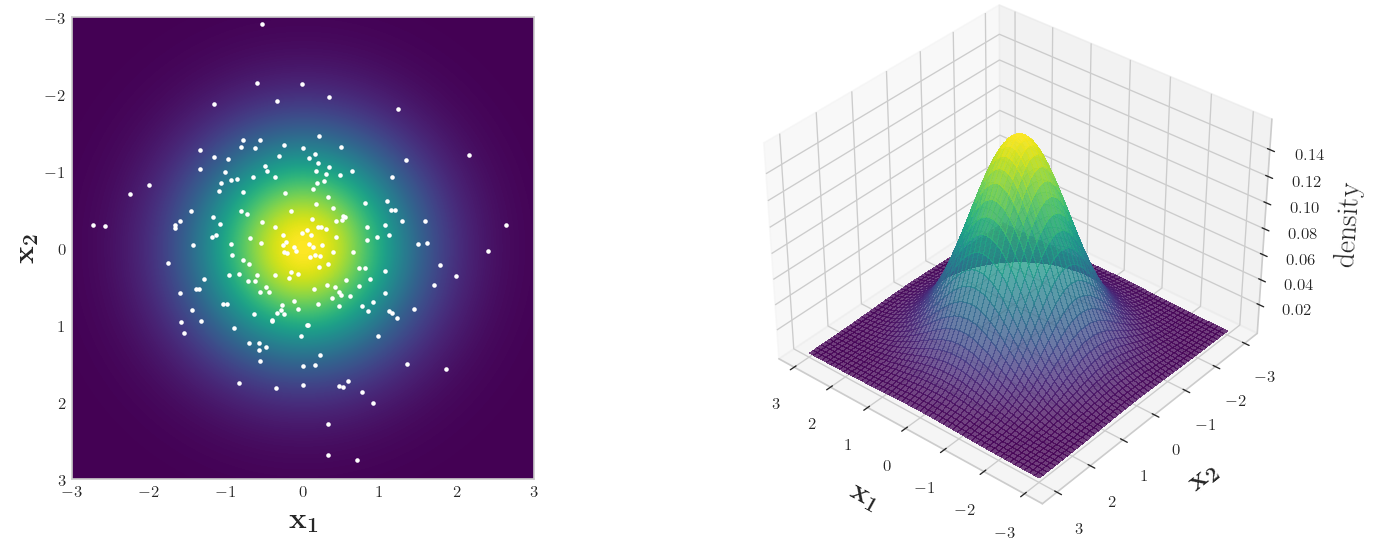

In [3]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure(facecolor=(1,1,1), figsize=(14,5))

x_min, x_max, y_min, y_max = -3, 3, -3, 3

""" LEFT PLOT """
ax = fig.add_subplot(1, 2, 1)
ax.imshow(probs1, origin="lower", cmap="viridis", extent=[x_min,x_max,y_max,y_min])

torch.manual_seed(78537)
ax.scatter(mvn1.sample([100]), mvn1.sample([100]), c="white", s=3)
plt.grid(None)

# Axis labels
ax.set_xlabel(r'$\bf{x}_1$', fontsize=18)
ax.set_ylabel(r'$\bf{x}_2$', fontsize=18)

""" RIGHT PLOT """
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X_grid, Y_grid, probs1, cmap=cm.viridis, antialiased=False, alpha=0.75)

# Axis labels
ax.set_xlabel(r'$\bf{x}_1$', fontsize=18)
ax.set_ylabel(r'$\bf{x}_2$', fontsize=18)
ax.set_zlabel(r'$\textrm{density}$', fontsize=18)

ax.view_init(35, 130)
ax.dist = 8.5

In the left plot, the dots indicate points samples from this distribution. The right plot shows the left one in 3D. Each axis denotes the probability of the first or second element of the vector $\boldsymbol{x}$ being anywhere from $-3$ to $3$. 

What about the covariance matrices? The covariance matrix affects the way that the samples are spread about the mean. Since we are in two dimensions there are more ways that samples can spread rather than just left to right as we see in univariate distribution. We can compre the shapes of different probability distributions with different covariance matrices easily. Let's make a function that will plot a generic bivariate normal distribution, centered at the origin, for different types of covariance matrices.

In the `bivariate_normal()` function, we create grid, create a probability distribution based on a specified covariance matrix, and sample from it. We can then plot each distribution with a different covariance matrix to see what they look like.

In [4]:
def bivariate_normal(cov_entries: list, seed: int):
    # Create grid
    cov_11, cov_12, cov_21, cov_22 = cov_entries
    grid, _, _ = generate_grid(x_min=-4, x_max=4, y_min=-4, y_max=4, g_size=0.01)
    
    # Create bivariate normal centered at zero with covariance matrix input to function
    mu    = torch.tensor([0.,0.])             # Mean of the distribution
    cov   = torch.tensor([[cov_11, cov_12],   # Covariance matrix of the distribution
                        [cov_21, cov_22]])

    mvn   = MultivariateNormal(loc=mu, covariance_matrix=cov)
    probs = np.exp(mvn.log_prob(grid))        # Compute log-prob and then exponentiate to get back the probability
    
    # Samples 30 points from the created distribution
    torch.manual_seed(seed)
    samples_x = mvn.sample([30])
    samples_y = mvn.sample([30])
    samples = [samples_x, samples_y]
    
    return probs, samples

Here we define the four different distributions we wish to plot with different covariance matrices.

In [5]:
# Spherical covariances
spherical_cov = [1., 0., 0., 1.]
spherical_probs, spherical_samples = bivariate_normal(spherical_cov, seed=3432)
spherical_text = r"$\begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$"

# Up-down covariances
ud_cov = [0.5, 0., 0., 7.]
ud_probs, ud_samples = bivariate_normal(ud_cov, seed=3258)
ud_text = r"$\begin{bmatrix} 0.5 & 0 \\ 0 & 7 \end{bmatrix}$"

# Left-right diagonal covariance
lrd_cov = [4., 2., 2., 4.]
lrd_probs, lrd_samples = bivariate_normal(lrd_cov, seed=3388)
lrd_text = r"$\begin{bmatrix} 4 & 2 \\ 2 & 4 \end{bmatrix}$"

# Right-left diagonal covariance
rld_cov = [1., -0.5, -0.5, 1.]
rld_probs, rld_samples = bivariate_normal(rld_cov, seed=3388)
rld_text = r"$\begin{bmatrix} 1 & -0.5 \\ -0.5 & 1 \end{bmatrix}$"

<Figure size 768x576 with 0 Axes>

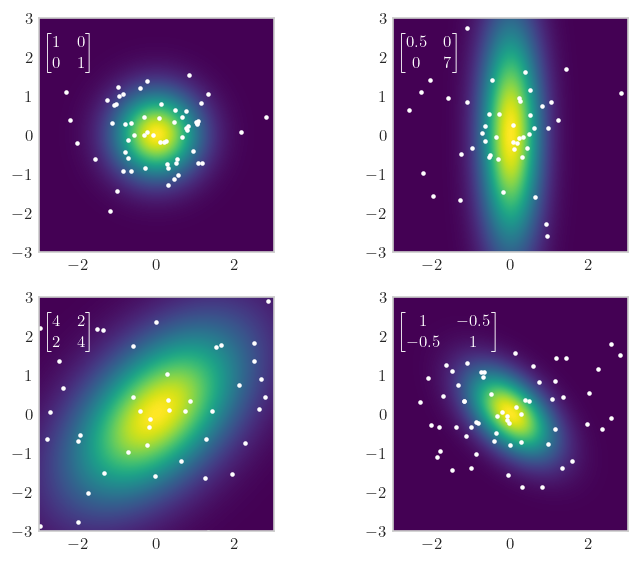

In [6]:
fig = plt.figure()
fig, axes = plt.subplots(2,2, facecolor=(1,1,1))

# Spherical covariances (top-left plot)
axes[0,0].imshow(spherical_probs.T, origin="lower", cmap="viridis", extent=[x_min,x_max,x_min,x_max])
axes[0,0].scatter(spherical_samples[0], spherical_samples[1], c="white", s=3)
axes[0,0].text(-2.8, 2, spherical_text, c="white")

# Up-down covariances (top-right plot)
axes[0,1].imshow(ud_probs.T, origin="lower", cmap="viridis", extent=[x_min,x_max,x_min,x_max])
axes[0,1].scatter(ud_samples[0], ud_samples[1], c="white", s=3)
axes[0,1].text(-2.8, 2, ud_text, c="white")

# Up-down covariances (top-right plot)
axes[1,0].imshow(lrd_probs.T, origin="lower", cmap="viridis", extent=[x_min,x_max,x_min,x_max])
axes[1,0].scatter(lrd_samples[0], lrd_samples[1], c="white", s=3)
axes[1,0].text(-2.8, 2, lrd_text, c="white")

# Up-down covariances (top-right plot)
axes[1,1].imshow(rld_probs.T, origin="lower", cmap="viridis", extent=[x_min,x_max,x_min,x_max])
axes[1,1].scatter(rld_samples[0], rld_samples[1], c="white", s=3)
axes[1,1].text(-2.8, 2, rld_text, c="white")

for r in range(2):
    for c in range(2):
        axes[r, c].set_xlim(-3, 3)
        axes[r, c].set_ylim(-3, 3)
        axes[r, c].grid(None)

fig.tight_layout()

As we can clearly see, the distributions are still centered around $(0,0)$ but the way that they spread around it varies depending on the covariance matrix we choose. 

* The top-left covariance matrix is **spherical**, also known as **isotropic**. This means all diagonal values are identical so we may sometimes write it as $\sigma^2 \boldsymbol{I}$ denoting a diagonal matrix with the same entries, defined by $\sigma^2$. 
* The top-right covariance matrix is **diagonal**. This means that this matrix only has values on the diagonal but we no longer require these values to be the same. We will sometimes denote this as $\sigma^2_p \boldsymbol{I}$, indicating a vector of variances of size $p$ multipled by the identity matrix (of size $p \times p$).
* The bottom row shows covariance matrices that we will informally call *tilted*. This is a result of filling in the off-diagonal values.

The covariance matrix diagonals are just the variance of each sample (how each element of $\boldsymbol{x}$ varies with itself). But the off-diagonals add in a new twist that was not possible with univariate distributions. It tells us how each element of $\boldsymbol{x}$ varies with the other element in $\boldsymbol{x}$. It is this property that allows us to display more complex shapes of the distributions which are tilted. For distributions with elements greater than $2$ which we cannot visualize the same idea applies.

Diagonal or spherical covariance matrices indicate uncorrelated noise sources. We will frequently use these types of covariance matrices in this book.

## Experiment 3E: Bayesian linear regression

Having now underestood multivariate distributions we are ready to use them for Bayesian linear regression. In Bayesian linear regression, we are interested in solving the following inference problem:

$$
p_{\Sigma_{\theta \mid y}, \mu_{\theta \mid y}}(\boldsymbol{\theta} \mid \boldsymbol{y}) = \frac{p_{\sigma^2_y, X}(\boldsymbol{y} \mid \boldsymbol{\theta}) p_{\mu_{\theta}, \sigma^2_{\theta}}(\boldsymbol{\theta})}{p(\boldsymbol{y})}
$$

This tells us that we are interesting in the posterior distribution over parameters. Unlike Experiment 3A-3C, we are not just interested in deterministic values for $\beta_0$ and $\beta_1$. Rather we want to collect them into a vector $\boldsymbol{\theta} = \begin{bmatrix} \beta_0 & \beta_1 \end{bmatrix}^T$ which we can represent with a multivariate normal distribution. This distribution is the posterior: Given what we have observed of the data, what is the distribution of the parameter vector? The variables of interest are represented as follows:

| Variable | Status     | Data type     |
|----------|------------|---------------|
| $x$      | observed   | deterministic |
| $y$      | observed   | probabilistic |
| $\theta$ | unobserved | **probabilistic** |
| $\phi$   | known      | deterministic |

Note that the likelihood takes in the data matrix $\boldsymbol{X}$ multiplied by $\boldsymbol{\theta}$. The output of this is a vector which means the likelihood is represented by a multivariate normal distribution. Likewise, the prior and posterior are also multivariate normal distributions.

The first step is to create the environment, The environment is designed to return the data matrix to use for convenience. Each vector $\boldsymbol{x}$ has a $1$ inserted in front and is then stacked row-by-row into a matrix. We also include a function `get_prior_probs()` which returns the probabilities for a prior of our choice.

What about the posterior? Well as it turns out, we can easily obtain the posterior mean and covariance matrix with two equations. This obviates the need to utilize Bayesian inference as we have done in previous chapters. Like Experiment 3A and 3B, we can obtain a closed form solution for the posterior. The equations are

$$
\begin{align}
    \boldsymbol{\Sigma}_{\theta \mid y} &=  (\sigma^{-2} \boldsymbol{X}^T \boldsymbol{X} + \boldsymbol{\Sigma}^{-1}_{\theta} )^{-1} \\
    \boldsymbol{\mu}_{\theta \mid y} &= \boldsymbol{\Sigma}_{\theta \mid y}(\sigma^{-2} \boldsymbol{X}^T \boldsymbol{y} + \boldsymbol{\Sigma}^{-1}_{\theta} \boldsymbol{\mu}_{\theta})
\end{align}
$$

These equations are directly implemented in `get_posterior_probs()` below.

In [7]:
def environment(x_range, p, theta, n, var_y):
    
    X = []
    for sample in range(n): 
        # np.random.seed(5345)
        x = np.random.choice(x_range, size=p-1)
        x = np.insert(x, 0, 1)
        X.append(x)
        
    X = torch.tensor(np.array(X, dtype=np.float64))
    y = Normal(loc=X @ theta, scale=np.sqrt(var_y)).sample()
    
    return X, y

def create_grid(x_min: int, x_max: int):
    X_grid, y_grid = np.mgrid[x_min:x_max:.01, x_min:x_max:.01]
    grid = np.dstack((X_grid, y_grid))
    return grid
    
def get_prior_probs(mu_theta, cov_theta, grid):
    prior = MultivariateNormal(mu_theta, cov_theta)
    prior_log_probs = prior.log_prob(torch.tensor(grid))
    return np.exp(prior_log_probs)

def get_posterior_probs(X, y, cov_x, mu_x, var_y, grid):
    
    p_y = 1 / var_y
    y = y[:, np.newaxis]
    
    cov_posterior = torch.linalg.inv(torch.linalg.inv(cov_x) + p_y * X.t() @ X)
    mean_posterior = cov_posterior @ (torch.linalg.inv(cov_x) @ mu_x.float() + p_y * X.t() @ y)
    mean_posterior = np.diag(mean_posterior)
    
    posterior = MultivariateNormal(torch.tensor(mean_posterior.flatten()), torch.tensor(cov_posterior))
    posterior_log_probs = posterior.log_prob(torch.tensor(grid))
    return np.exp(posterior_log_probs)

Now we set up the experiment. We need to specify the grid for the two axis of the posterior. These will be the range of values that we want to display for $\beta_0$ on one axis and $\beta_1$ on the other. Our grid ranges from $-4$ to $4$ on each axis. We will generate 500 samples of $\boldsymbol{x}$, collected in a data matrix $\boldsymbol{X}$ which is used to compute $\boldsymbol{y}$ through the linear equation $\boldsymbol{\theta} \boldsymbol{X} + \boldsymbol{\varepsilon}$. We use a spherical prior with a covariance matrix of $0.5 \boldsymbol{I}$. 

In [8]:
# Grid setup
x_min = -4
x_max = 4
x_range = torch.linspace(start=x_min, end=x_max, steps=500)

# Get grid
grid = create_grid(x_min, x_max)

# Environment setup
n = 500                    # Number of samples
theta = np.array([3, 2])   # True theta
p = len(theta)             # DImension of theta
var_y = 0.5                # Generative noise

# Sample environment
X, y = environment(x_range, p, theta, n, var_y)

# Prior hyperparameters setup
mu_theta = torch.tensor(np.array([0., 0.]))   # Dimension of theta prior mean [p x 1]
cov_theta = 0.5 * torch.eye(2)                # Dimension of theta prior covariance matrix [p x p]

Our goal will be to plot the posterior at different numbers of samples of $x$. We can do this easily with the `get_posterior_probs()` function.

In [9]:
prior_probs = get_prior_probs(mu_theta, cov_theta, grid)
posterior_probs_1 = get_posterior_probs(X[:1], y[:1], cov_theta, mu_theta, var_y, grid)
posterior_probs_5 = get_posterior_probs(X[:5], y[:5], cov_theta, mu_theta, var_y, grid)
posterior_probs_10 = get_posterior_probs(X[:10], y[:10], cov_theta, mu_theta, var_y, grid)
posterior_probs_15 = get_posterior_probs(X[:15], y[:15], cov_theta, mu_theta, var_y, grid)
posterior_probs_50 = get_posterior_probs(X[:50], y[:50], cov_theta, mu_theta, var_y, grid)

probs_list = [prior_probs, posterior_probs_1, posterior_probs_5, posterior_probs_10, posterior_probs_15, posterior_probs_50]

/tmp/ipykernel_3590/497586713.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = MultivariateNormal(torch.tensor(mean_posterior.flatten()), torch.tensor(cov_posterior))


<Figure size 768x576 with 0 Axes>

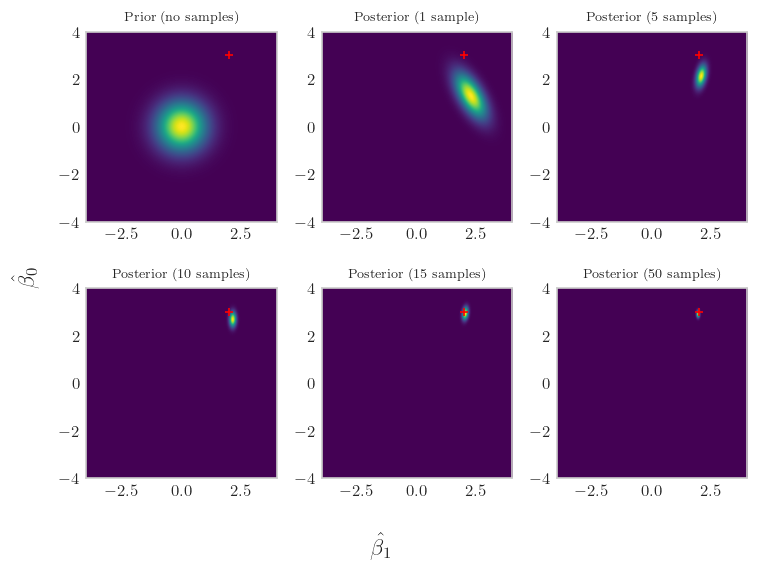

In [12]:
fig = plt.figure()
fig, axes = plt.subplots(2,3, facecolor=(1,1,1))

# Plot the distributions
for ax, data in zip(axes.reshape(-1), probs_list): 
    ax.imshow(data, origin="lower", cmap="viridis", extent=[x_min,x_max,x_min,x_max])
    ax.plot(2, 3, marker="+", color="red", markersize=5)
    ax.grid(None)

# Titles
axes[0,0].set_title(r"$\textrm{Prior (no samples)}$", fontsize=8)
axes[0,1].set_title(r"$\textrm{Posterior (1 sample)}$", fontsize=8)
axes[0,2].set_title(r"$\textrm{Posterior (5 samples)}$", fontsize=8)
axes[1,0].set_title(r"$\textrm{Posterior (10 samples)}$", fontsize=8)
axes[1,1].set_title(r"$\textrm{Posterior (15 samples)}$", fontsize=8)
axes[1,2].set_title(r"$\textrm{Posterior (50 samples)}$", fontsize=8)
    
fig.supxlabel(r'$ \hat{\beta_1}$', fontsize=14)
fig.supylabel(r'$ \hat{\beta_0}$', fontsize=14)   

fig.tight_layout()



As we can see, as we obtain more samples our distribution narrows and becomes more confident about the true values. 